In [45]:
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import json

# Retrive POIs in D.C.

In [2]:
# read census tract boundary in DC
dc_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_11_tract.zip")

In [3]:
print(dc_census_tract.total_bounds)

[-77.119759  38.791645 -76.909393  38.995845]


In [4]:
# Define the bboxing of Washington, D.C.
dc_bbox = "38.791645,-77.119759,38.995845,-76.909393 "

In [28]:
# Define the Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Define the Overpass query using the bounding box variable
dc_eatery_overpass_query = f"""
[out:json][timeout:25];

(
  node["amenity"="restaurant"]({dc_bbox});
  node["amenity"="cafe"]({dc_bbox});
  node["amenity"="bar"]({dc_bbox});
  node["amenity"="biergarten"]({dc_bbox});
  node["amenity"="pub"]({dc_bbox});
  
);
out body;
>;
out skel qt;
"""

# Make the request
dc_eatery_response = requests.get(overpass_url, params={'data': dc_eatery_overpass_query})
dc_eatery_dict = dc_eatery_response.json()

# Convert the data into a pandas DataFrame
dc_eatery_list = [] # Create a list for the initilization of the dataframe
for element in dc_eatery_dict['elements']:
    latitude = element['lat']
    longitude = element['lon']
    name = element.get('tags', {}).get('name', 'n/a')
    amenity = element.get('tags', {}).get('amenity', 'n/a')
    dc_eatery_list.append({
        'Name': name,
        'Type': amenity,
        'Latitude': latitude,
        'Longitude': longitude
    })

# Create the DataFrame using the list
dc_eatery_df = pd.DataFrame(dc_eatery_list)

# Show the DataFrame
dc_eatery_df

,Name,Type,Latitude,Longitude
0,Cafe Saint Ex,bar,38.915421,-77.031701
1,Millie’s,restaurant,38.945050,-77.096330
2,Buzz Bakeshop,cafe,38.821596,-77.047646
3,Euro Market,cafe,38.891441,-77.086067
4,Mamma Lucia,restaurant,38.990991,-77.029690
...,...,...,...,...
2290,Café Con Bagel,cafe,38.907573,-77.063560
2291,Donahue DC,restaurant,38.907631,-77.063620
2292,Georgetown Seafood,restaurant,38.905525,-77.065083
2293,Gong Cha,cafe,38.905273,-77.065405


# Aggregate POIs into each census tract in D.C.
* https://octo.dc.gov/page/coordinate-system-standards

In [29]:
# read census tract boundary in DC
dc_census_tract_rprj = dc_census_tract.to_crs("EPSG:26986")

In [30]:
# Create a GeoDataFrame for `dc_eatery_df`
dc_eatery_gdf = gpd.GeoDataFrame(dc_eatery_df.copy(), geometry=gpd.points_from_xy(dc_eatery_df.Longitude, dc_eatery_df.Latitude), crs = dc_census_tract.crs) #"EPSG:4326"

# Reproject the `dc_eatery_gdf` to match the CRS of the `dc_census_tract_rprj` GeoDataFrame
dc_eatery_gdf_prj = dc_eatery_gdf.to_crs(dc_census_tract_rprj.crs)

# Perform a spatial join between the reprojected eatery points and the census tracts.
# This assigns each eatery to a census tract if it is within the tract's boundaries.
dc_eatery = gpd.sjoin(dc_eatery_gdf_prj, dc_census_tract_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_ct_eatery = dc_eatery.assign(count = np.ones(dc_eatery.shape[0]))
dc_ct_eatery = dc_ct_eatery.groupby('GEOID')['count'].sum().reset_index()

# Merge the eatery counts with the census tracts GeoDataFrame
dc_ct_pois = dc_census_tract_rprj.merge(dc_ct_eatery, on='GEOID', how='left')

# Replace NaN values with 0 for tracts without eatery
dc_ct_pois['count'] = dc_ct_pois['count'].fillna(0)

# Rename the 'count' column to 'eatery_count'
dc_ct_pois.rename(columns={'count': 'eatery_count'}, inplace=True)

# Basic Visualization

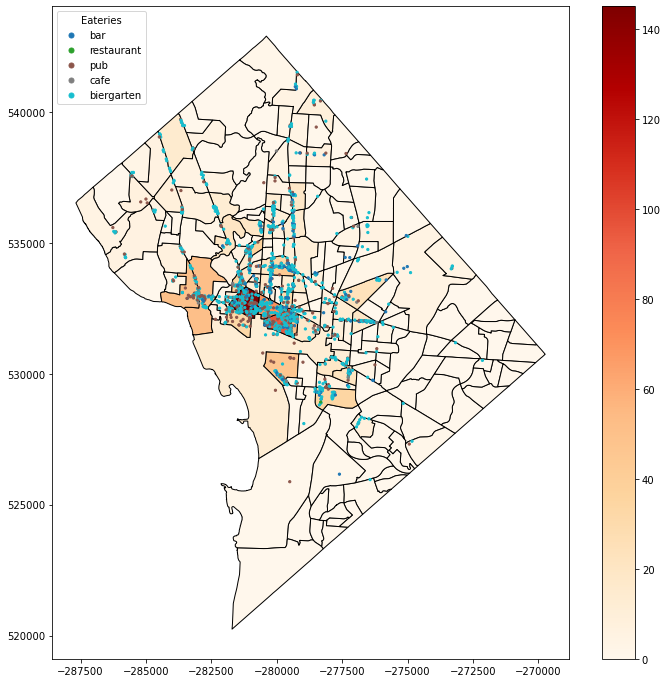

In [62]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(12,12))

# Plot the census tracts with color based on 'eatery_count'
dc_ct_pois.plot(ax=ax, column='eatery_count', legend=True, cmap='OrRd', linewidth=1, edgecolor='black')

# Plot the eateries with color based on 'Type'
dc_eatery.plot(ax=ax, marker='o', markersize=5, column='Type', legend=False, cmap='tab10')

# Get unique types and their corresponding colors from the colormap
unique_types = dc_eatery['Type'].unique()
cmap = cm.get_cmap('tab10', len(unique_types))  # Get the colormap
norm = Normalize(vmin=0, vmax=len(unique_types) - 1)  # Normalize for the number of unique types

# Create a legend entry for each unique type
legend_elements = [Line2D([0], [0], marker='o', color=cmap(norm(i)), lw=0, markersize=5, label=type) for i, type in enumerate(unique_types)]

# Add the legend for eateries
ax.legend(handles=legend_elements, loc='upper left', title='Eateries')

# Show the plot
plt.show()